<a href="https://colab.research.google.com/github/drdips/carcinoma_classification/blob/master/workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_USERNAME'] = "diptaroy" # username from the json file
os.environ['KAGGLE_KEY'] = "c4c1899a45f60acb8e710d7a4e0afb05" # key from the json file

In [2]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [01:45<00:00, 37.9MB/s]
100% 3.10G/3.10G [01:45<00:00, 31.5MB/s]


In [3]:
!unzip -q breast-histopathology-images.zip 

In [4]:
images_folder = '/content/IDC_regular_ps50_idx5'

In [5]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
# from scipy.misc import imresize, imread
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
#let's take a look at if we're in the right folder
imagePatches = glob('/content/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches[0:15]:
    print(filename)

/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x1101_y1251_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x1301_y1401_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x101_y1351_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x251_y1251_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x351_y1201_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x651_y1251_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x1801_y1451_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x901_y1001_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x651_y1351_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x651_y1051_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x401_y801_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x1501_y1251_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x951_y1151_class0.png
/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x1101_y1051

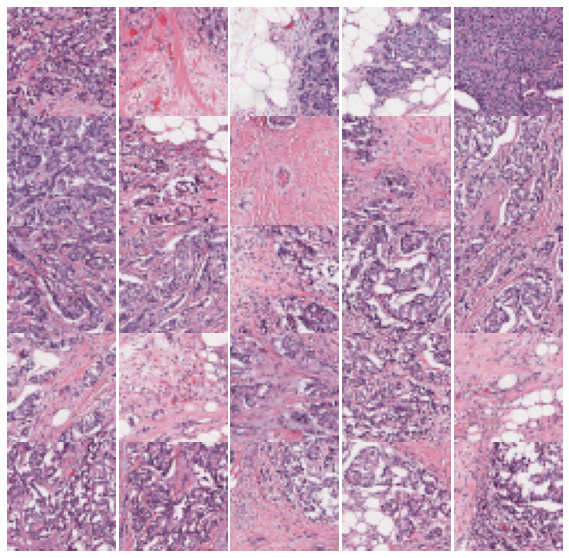

In [ ]:
#let's look at the first 25 images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [7]:
classZero = '*class0.png'
classOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, classZero)
classOne = fnmatch.filter(imagePatches, classOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x1101_y1251_class0.png', '/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x1301_y1401_class0.png', '/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x101_y1351_class0.png', '/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x251_y1251_class0.png', '/content/IDC_regular_ps50_idx5/13458/0/13458_idx5_x351_y1201_class0.png'] 

IDC(+)

 ['/content/IDC_regular_ps50_idx5/13458/1/13458_idx5_x601_y651_class1.png', '/content/IDC_regular_ps50_idx5/13458/1/13458_idx5_x551_y601_class1.png', '/content/IDC_regular_ps50_idx5/13458/1/13458_idx5_x651_y801_class1.png', '/content/IDC_regular_ps50_idx5/13458/1/13458_idx5_x601_y551_class1.png', '/content/IDC_regular_ps50_idx5/13458/1/13458_idx5_x451_y601_class1.png']


LET"S GET READY TO PULL OUR DATA!

In [8]:
#We'll pull our data in the 50 by 50 pixel size
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    patient = []
    WIDTH = 50
    HEIGHT = 50

    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT)))
        patient.append(img)


        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y, patient

In [9]:
#turns out we have a huge imbalance so when we pull our data we'll pull more positives than negatives to balance it
def only_ones(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    patient = []
    WIDTH = 50
    HEIGHT = 50

    for img in imagePatches[lowerIndex:upperIndex]:

        if img in classOne:
            full_size_image = cv2.imread(img)
            x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT)))
            patient.append(img)
            y.append(1)
        elif img in classZero:
            continue
        else:
            return
    return x,y, patient

In [ ]:
#How many pictures do we have?
from os import listdir
base_path = "/content/IDC_regular_ps50_idx5/"
folder = listdir(base_path)


total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)
total_images

277524

Since we have about 277,524 pictures and have a huge imbalance what we can do is import a lot of the pictures then only import the positive IDC pictures that way we can have a better balance. 

In [10]:

A,B, patient1 = proc_images(0,50000)


In [11]:
#we have a huge imbalance so let's pull some positives 
C,D, patient2 = only_ones(50001,80000)


In [12]:
X_test, Y_test, patient = proc_images(80001,100000)


In [13]:
X = np.concatenate([A, C], axis=0)
Y = np.concatenate([B, D], axis=0)
patient = np.concatenate([patient1, patient2], axis=0)

In [14]:
X.shape

(57888, 50, 50, 3)

In [ ]:
df1= pd.DataFrame()
df1["images"]=A
df1["labels"]=B
df1['id']=patient1
df2 = pd.DataFrame()
df2['images']=C
df2['labels']=D
df2['id'] = patient2

df= pd.concat([df1,df2])

X2=df["images"]
Y2=df["labels"]
X2=np.array(X2)
imgs0=[]
imgs1=[]
imgs0 = X2[Y2==0] # (0 = no IDC, 1 = IDC)
imgs1 = X2[Y2==1] # these come in later when we want to visualize the differences between IDC(-) and IDC(+)

In [ ]:
#To add patient ID to the dataframe
# df['id'] = patient
df['patient_id']=df['id'].apply(lambda x: x.split('/')[3])
df.drop(labels='id', axis=1, inplace=True)

In [ ]:
df.labels.value_counts().sum()

39924

In [ ]:
df2.shape

(19924, 3)

In [ ]:
df[df['labels']==1].head(2)

,images,labels
0,"[[[134, 75, 135], [176, 128, 191], [157, 105, ...",1
1,"[[[211, 184, 205], [206, 181, 205], [182, 144,...",1


In [ ]:
df.groupby("patient_id").size()

patient_id
10253      70
10260    1289
10269    1154
10274     878
10278      91
         ... 
9262       94
9267      591
9319      416
9324     1042
9325     1128
Length: 80, dtype: int64

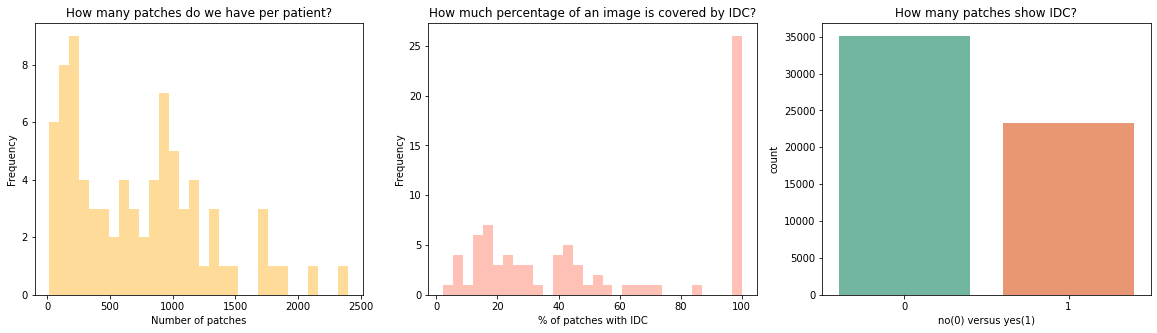

In [ ]:
cancer_perc = df.groupby("patient_id").labels.value_counts()/ df.groupby("patient_id").labels.size()
cancer_perc = cancer_perc.unstack()

fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.distplot(df.groupby("patient_id").size(), ax=ax[0], color="Orange", kde=False, bins=30)
ax[0].set_xlabel("Number of patches")
ax[0].set_ylabel("Frequency");
ax[0].set_title("How many patches do we have per patient?");
sns.distplot(cancer_perc.loc[:, 1]*100, ax=ax[1], color="Tomato", kde=False, bins=30)
ax[1].set_title("How much percentage of an image is covered by IDC?")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("% of patches with IDC");
sns.countplot(df.labels, palette="Set2", ax=ax[2]);
ax[2].set_xlabel("no(0) versus yes(1)")
ax[2].set_title("How many patches show IDC?");

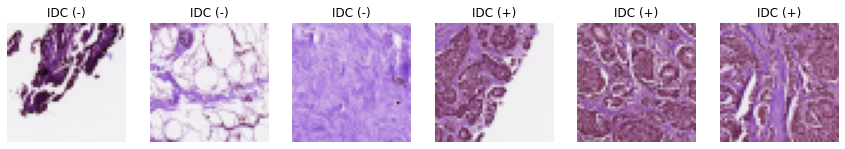

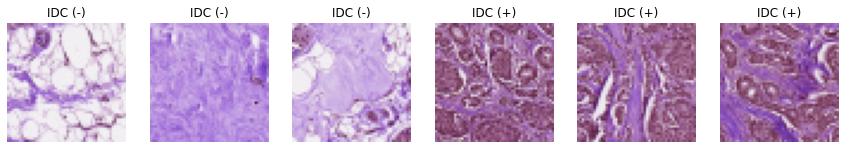

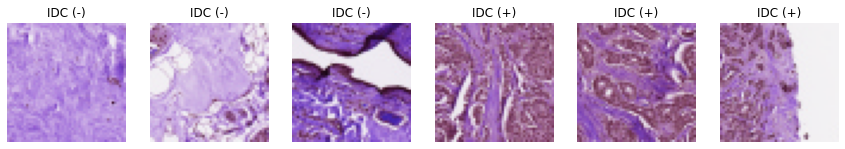

In [ ]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[0+row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[0+row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 

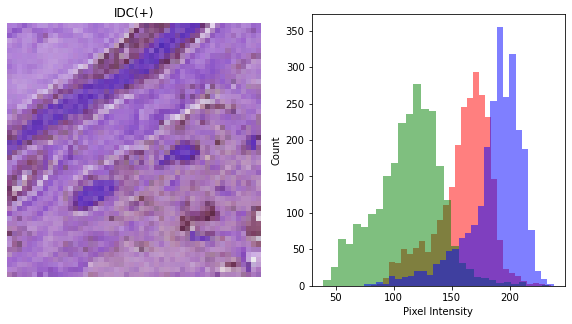

In [ ]:
#It's hard to tell from the images above what constitutes a cancerous histology image vs a non cancerous maybe we can try to see if there are any differences in color
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X2[100])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   images      20000 non-null  object
 1   labels      20000 non-null  int64 
 2   patient_id  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB


In [15]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2)
# X_train, X_val, Y_train, Y_val = train_test_split(X_model, Y_model, test_size=0.2)

In [16]:
from keras.utils.np_utils import to_categorical
X_train=np.array(X_train)/255
y_trainHot = to_categorical(Y_train, num_classes = 2)

X_test=np.array(X_test)/255
y_testHot = to_categorical(Y_test, num_classes = 2)

X_val=np.array(X_val)/255 
y_valHot = to_categorical(Y_val, num_classes = 2)

**Baseline Model - Dummy Classifier**

In [18]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_trainHot)
dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_testHot)

0.6649332466623331

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(50,50,3),strides=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 24, 24, 32)        896       
_________________________________________________________________
flatten_9 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               2359424   
_________________________________________________________________
dropout_24 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 258       
Total params: 2,360,578
Trainable params: 2,360,578
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(X_train, y_trainHot ,batch_size=62,epochs =22, validation_data=(X_val, y_valHot))

Epoch 1/22
765/765 [==============================] - 3s 4ms/step - loss: 0.5531 - accuracy: 0.7257 - val_loss: 0.5013 - val_accuracy: 0.7832
Epoch 2/22
765/765 [==============================] - 3s 3ms/step - loss: 0.4844 - accuracy: 0.7830 - val_loss: 0.4240 - val_accuracy: 0.8166
Epoch 3/22
765/765 [==============================] - 3s 3ms/step - loss: 0.4580 - accuracy: 0.7972 - val_loss: 0.4164 - val_accuracy: 0.8140
Epoch 4/22
765/765 [==============================] - 3s 3ms/step - loss: 0.4393 - accuracy: 0.8083 - val_loss: 0.5300 - val_accuracy: 0.7668
Epoch 5/22
765/765 [==============================] - 3s 3ms/step - loss: 0.4310 - accuracy: 0.8127 - val_loss: 0.4000 - val_accuracy: 0.8260
Epoch 6/22
765/765 [==============================] - 3s 3ms/step - loss: 0.4221 - accuracy: 0.8150 - val_loss: 0.4157 - val_accuracy: 0.8138
Epoch 7/22
765/765 [==============================] - 3s 3ms/step - loss: 0.4190 - accuracy: 0.8160 - val_loss: 0.4233 - val_accuracy: 0.8056
Epoch 

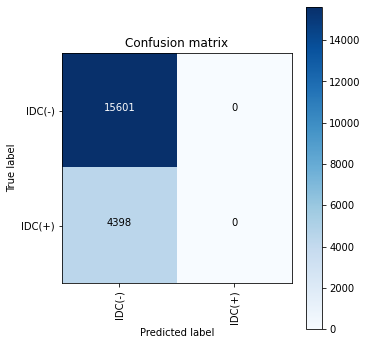

SyntaxError: ignored

In [ ]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()
return Y_pred_classes, Y_true

In [ ]:
def graph_epoch(history, epoch):
  epochs = [i for i in range(epoch)]
  fig , ax = plt.subplots(1,2)
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']
  fig.set_size_inches(10,6)

  ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
  ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
  ax[0].set_title('Training & Validation Accuracy')
  ax[0].legend()
  ax[0].set_xlabel("Epochs")
  ax[0].set_ylabel("Accuracy")

  ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
  ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
  ax[1].set_title('Testing Accuracy & Loss')
  ax[1].legend()
  ax[1].set_xlabel("Epochs")
  ax[1].set_ylabel("Training & Validation Loss")
  plt.show()

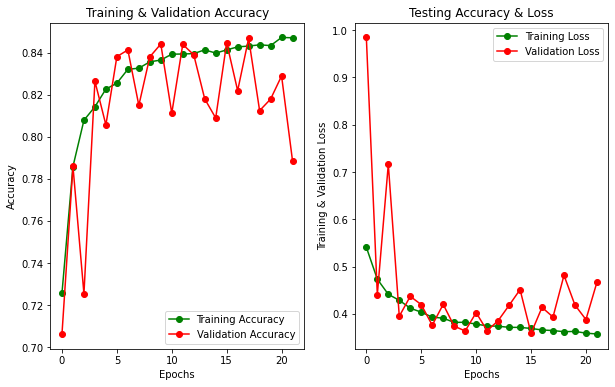

In [ ]:
graph_epoch(history, 22)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
def y_pred(model):
  y_pred = model.predict(X_test)
  Y_pred_classes = np.argmax(y_pred,axis=1) 
  Y_true = np.argmax(y_testHot,axis=1)
  dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
  confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
  plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
  plt.show()
  return Y_pred_classes, Y_true

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes, target_names = ['IDC (-)','IDC (+)']))



              precision    recall  f1-score   support

     IDC (-)       0.78      1.00      0.88     15611
     IDC (+)       0.00      0.00      0.00      4388

    accuracy                           0.78     19999
   macro avg       0.39      0.50      0.44     19999
weighted avg       0.61      0.78      0.68     19999



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(50,50,3),strides=2))

model.add(Conv2D(64, kernel_size=(3, 3),
                 activation='relu',strides=2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(2, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 24, 24, 32)        896       
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_7 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               991360    
_________________________________________________________________
dropout_22 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 1,011,010
Trainable params: 1,011,010
Non-trainable params: 0
____________________________________________

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(X_train, y_trainHot ,batch_size=100,epochs = 5, validation_data=(X_val, y_valHot), callbacks=[learning_rate_reduction])

Epoch 1/5
474/474 [==============================] - 2s 5ms/step - loss: 0.5875 - accuracy: 0.6874 - val_loss: 0.4723 - val_accuracy: 0.7885
Epoch 2/5
474/474 [==============================] - 2s 4ms/step - loss: 0.5011 - accuracy: 0.7757 - val_loss: 0.4315 - val_accuracy: 0.8111
Epoch 3/5
474/474 [==============================] - 2s 5ms/step - loss: 0.4740 - accuracy: 0.7886 - val_loss: 0.4329 - val_accuracy: 0.8017
Epoch 4/5
465/474 [============================>.] - ETA: 0s - loss: 0.4541 - accuracy: 0.7999
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
474/474 [==============================] - 2s 4ms/step - loss: 0.4550 - accuracy: 0.7993 - val_loss: 0.5183 - val_accuracy: 0.7678
Epoch 5/5
474/474 [==============================] - 2s 5ms/step - loss: 0.4198 - accuracy: 0.8142 - val_loss: 0.4026 - val_accuracy: 0.8268


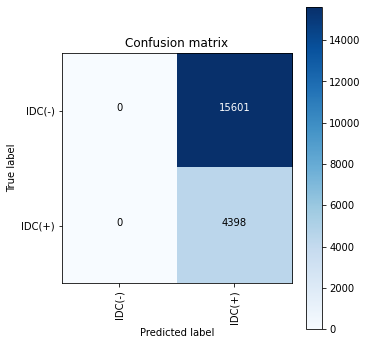

(array([1, 1, 1, ..., 1, 1, 1]), array([0, 0, 0, ..., 1, 0, 0]))

In [ ]:
y_pred(model)

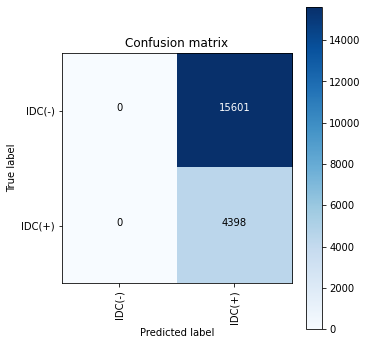

In [ ]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

In [ ]:
y_pred

array([[0.21790761, 0.7820924 ],
       [0.21786864, 0.7821313 ],
       [0.21789019, 0.7821098 ],
       ...,
       [0.21798815, 0.7820118 ],
       [0.2179017 , 0.7820983 ],
       [0.2179425 , 0.78205746]], dtype=float32)

In [ ]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (50,50,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 2 , activation = 'softmax'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
# model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.SGD(),
#               metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 50, 50, 32)        896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
dropout_16 (Dropout)         (None, 25, 25, 64)        0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 25, 25, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 64)       

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(X_train, y_trainHot ,batch_size=100,epochs = 5, validation_data=(X_val, y_valHot), callbacks=[learning_rate_reduction])

Epoch 1/5
474/474 [==============================] - 6s 12ms/step - loss: 0.4224 - accuracy: 0.8336 - val_loss: 0.5619 - val_accuracy: 0.7974
Epoch 2/5
474/474 [==============================] - 6s 12ms/step - loss: 0.3349 - accuracy: 0.8630 - val_loss: 0.3956 - val_accuracy: 0.8405
Epoch 3/5
474/474 [==============================] - 6s 12ms/step - loss: 0.3175 - accuracy: 0.8720 - val_loss: 0.7112 - val_accuracy: 0.5961
Epoch 4/5
471/474 [============================>.] - ETA: 0s - loss: 0.3099 - accuracy: 0.8744
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
474/474 [==============================] - 6s 12ms/step - loss: 0.3099 - accuracy: 0.8744 - val_loss: 0.5051 - val_accuracy: 0.8106
Epoch 5/5
474/474 [==============================] - 6s 12ms/step - loss: 0.2714 - accuracy: 0.8903 - val_loss: 0.3079 - val_accuracy: 0.8777


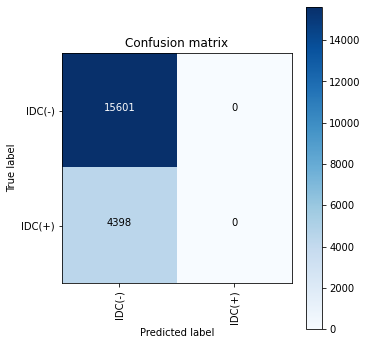

(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 1, 0, 0]))

In [ ]:
y_pred(model)

In [ ]:
print(classification_report(Y_true, Y_pred_classes, target_names = ['IDC (-)','IDC (+)']))

              precision    recall  f1-score   support

     IDC (-)       0.78      1.00      0.88     15611
     IDC (+)       0.00      0.00      0.00      4388

    accuracy                           0.78     19999
   macro avg       0.39      0.50      0.44     19999
weighted avg       0.61      0.78      0.68     19999



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


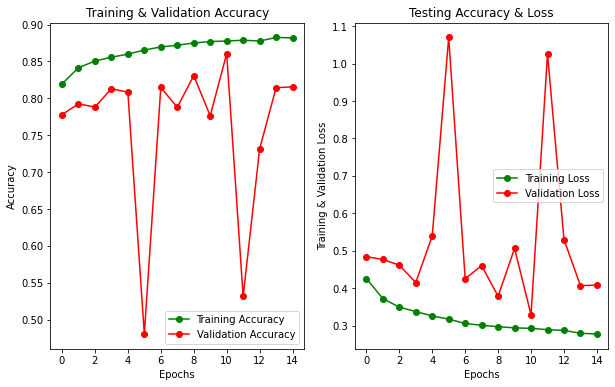

In [ ]:
graph_epoch(15)

In [ ]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
    def __len__(self):
        return self.steps_per_epoch
    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [ ]:
datagen = ImageDataGenerator(
        shear_range=0.2,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        rescale=1/255.0,
        horizontal_flip=True,
        vertical_flip=True) # define your data augmentation
balanced_gen = BalancedDataGenerator(X_train, y_trainHot, datagen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
history = model.fit_generator(balanced_gen, epochs=3, steps_per_epoch=steps_per_epoch, validation_data=(X_val, y_valHot))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Epoch 1/3
1752/1752 [==============================] - 44s 25ms/step - loss: 0.6942 - accuracy: 0.4991 - val_loss: 0.4778 - val_accuracy: 0.7787
Epoch 2/3
1752/1752 [==============================] - 44s 25ms/step - loss: 0.6934 - accuracy: 0.4982 - val_loss: 0.4796 - val_accuracy: 0.7775
Epoch 3/3
1752/1752 [==============================] - 45s 26ms/step - loss: 0.6933 - accuracy: 0.4971 - val_loss: 0.4802 - val_accuracy: 0.7767


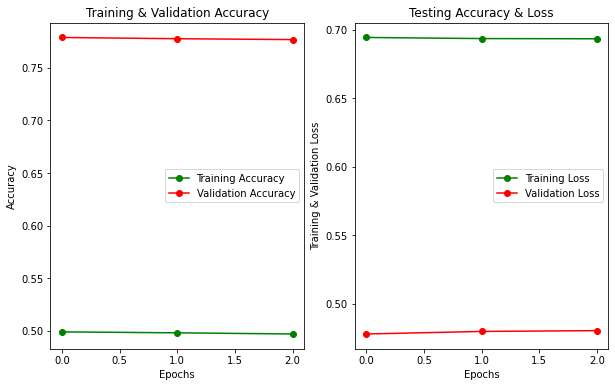

In [ ]:
graph_epoch(history, 3)

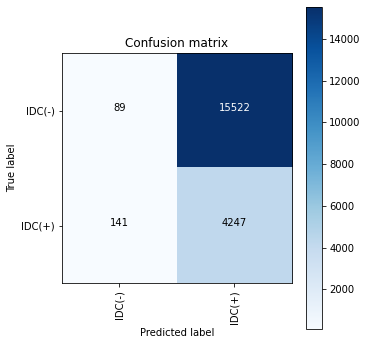

In [ ]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()


In [ ]:
print(classification_report(Y_true, Y_pred_classes, target_names = ['IDC (-)','IDC (+)']))


              precision    recall  f1-score   support

     IDC (-)       0.39      0.01      0.01     15611
     IDC (+)       0.21      0.97      0.35      4388

    accuracy                           0.22     19999
   macro avg       0.30      0.49      0.18     19999
weighted avg       0.35      0.22      0.09     19999



{0: 'IDC(-)', 1: 'IDC(+)'}


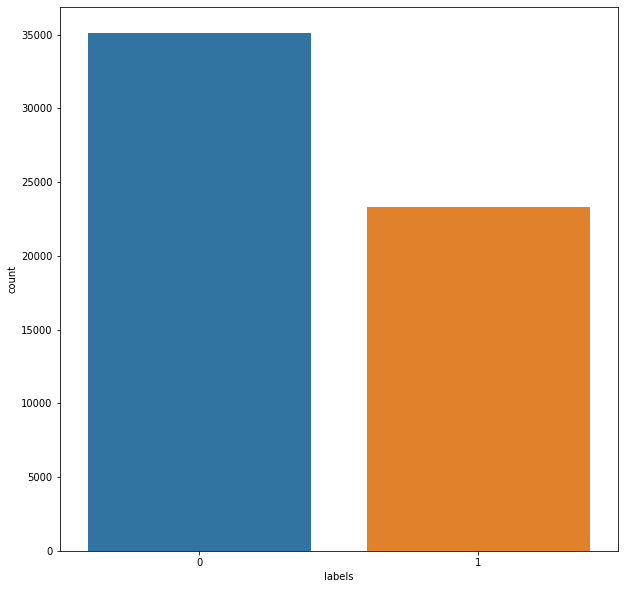

In [ ]:
lab = df['labels']
dist = lab.value_counts()
sns.countplot(lab)
print(dict_characters)

In [ ]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


{0: 'IDC(-)', 1: 'IDC(+)'}


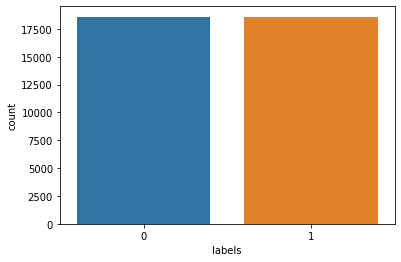

In [ ]:
# Deal with imbalanced class sizes below
# Make Data 1D for compatability upsampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)
#print("X_train Shape: ",X_train.shape)
#print("X_test Shape: ",X_test.shape)
#print("X_trainFlat Shape: ",X_trainFlat.shape)
#print("X_testFlat Shape: ",X_testFlat.shape)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
#ros = RandomOverSampler(ratio='auto')
ros = RandomUnderSampler(ratio='auto')
X_trainRos, Y_trainRos = ros.fit_sample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_sample(X_testFlat, Y_test)

# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)
#print("X_train: ", X_train.shape)
#print("X_trainFlat: ", X_trainFlat.shape)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_testRos Shape: ",X_testRos.shape)
#print("Y_trainRosHot Shape: ",Y_trainRosHot.shape)
#print("Y_testRosHot Shape: ",Y_testRosHot.shape)

for i in range(len(X_trainRos)):
    height, width, channels = 50,50,3
    X_trainRosReshaped = X_trainRos.reshape(len(X_trainRos),height,width,channels)
#print("X_trainRos Shape: ",X_trainRos.shape)
#print("X_trainRosReshaped Shape: ",X_trainRosReshaped.shape)

for i in range(len(X_testRos)):
    height, width, channels = 50,50,3
    X_testRosReshaped = X_testRos.reshape(len(X_testRos),height,width,channels)
#print("X_testRos Shape: ",X_testRos.shape)
#print("X_testRosReshaped Shape: ",X_testRosReshaped.shape)

dfRos = pd.DataFrame()
dfRos["labels"]=Y_trainRos
labRos = dfRos['labels']
distRos = lab.value_counts()
sns.countplot(labRos)
print(dict_characters)

In [ ]:
df_val = pd.DataFrame(y_valHot)
df_val.describe()

,0,1
count,11680.000000,11680.000000
mean,0.596318,0.403682
std,0.490651,0.490651
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,1.000000,1.000000
max,1.000000,1.000000


In [ ]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('./loss_curve.png')

In [ ]:
batch_size = 128
num_classes = 2
epochs = 8
img_rows,img_cols=50,50
input_shape = (img_rows, img_cols, 3)
e = 2

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape,strides=e))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
        

In [ ]:
a = X_train
b = y_trainHot
c = X_test
d = y_testHot
epochs = 10

In [ ]:
history = model.fit_generator(datagen.flow(a,b, batch_size=64),
                        epochs=epochs, validation_data=(X_val, y_valHot))

Epoch 1/10
730/730 [==============================] - 33s 46ms/step - loss: 0.5765 - accuracy: 0.7052 - val_loss: 0.4841 - val_accuracy: 0.7853
Epoch 2/10
730/730 [==============================] - 33s 45ms/step - loss: 0.4930 - accuracy: 0.7791 - val_loss: 0.4569 - val_accuracy: 0.7949
Epoch 3/10
730/730 [==============================] - 34s 46ms/step - loss: 0.4676 - accuracy: 0.7922 - val_loss: 0.4552 - val_accuracy: 0.7993
Epoch 4/10
730/730 [==============================] - 34s 46ms/step - loss: 0.4487 - accuracy: 0.8024 - val_loss: 0.4344 - val_accuracy: 0.8064
Epoch 5/10
730/730 [==============================] - 35s 47ms/step - loss: 0.4392 - accuracy: 0.8073 - val_loss: 0.4138 - val_accuracy: 0.8145
Epoch 6/10
730/730 [==============================] - 34s 47ms/step - loss: 0.4337 - accuracy: 0.8078 - val_loss: 0.4119 - val_accuracy: 0.8160
Epoch 7/10
730/730 [==============================] - 34s 46ms/step - loss: 0.4291 - accuracy: 0.8091 - val_loss: 0.4060 - val_accuracy:

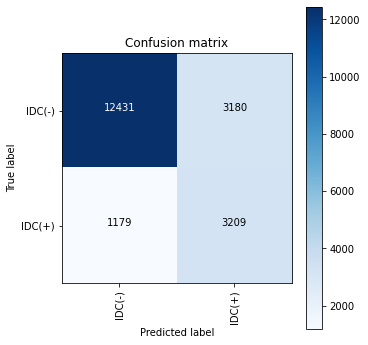

In [ ]:
y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(y_testHot,axis=1)
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes, target_names = ['IDC (-)','IDC (+)']))

              precision    recall  f1-score   support

     IDC (-)       0.91      0.80      0.85     15611
     IDC (+)       0.50      0.73      0.60      4388

    accuracy                           0.78     19999
   macro avg       0.71      0.76      0.72     19999
weighted avg       0.82      0.78      0.79     19999

